In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import os
import math
import librosa

DATASET_PATH = "/content/drive/MyDrive/Music Instrument/Indian Music Inst"
JSON_PATH = "/content/drive/MyDrive/Music Instrument/data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):


    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		# load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    # mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc)
                    mfcc=librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=40)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)


if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 130, 64)           26880     
                                                                 
 lstm_11 (LSTM)              (None, 64)                33024     
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 64,714
Trainable params: 64,714
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
35/35 [==============================]

AttributeError: ignored

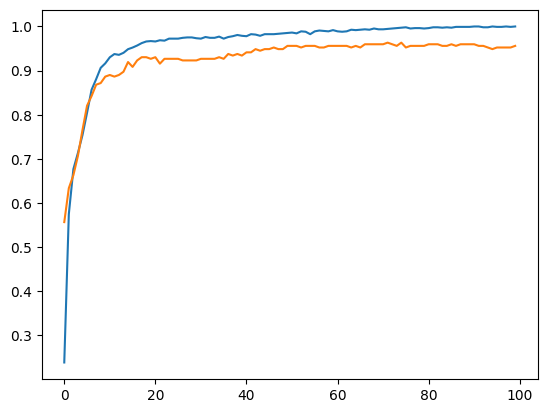

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATA_PATH = "/content/drive/MyDrive/Music Instrument/data_10.json"


def load_data(data_path):


    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):


    # build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))

    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2]) # 130, 13
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=150)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

In [ ]:
model.save("/content/drive/MyDrive/Music Instrument/Indian Music Inst/IndianInst.pb")

In [ ]:
import tensorflow as tf

# Load your saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/Music Instrument/IndianInst.pb')

# Convert the model to a TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Disable experimental lowering of tensor list ops
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

# Save the TFLite model to a file
with open('/content/drive/MyDrive/Music Instrument/Indian Music Inst/IndianInst.tflite', 'wb') as f:
    f.write(tflite_model)

KeyboardInterrupt: ignored

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Music Instrument/IndianInst.pb')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 130, 64)           26880     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 64,714
Trainable params: 64,714
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import librosa
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np
import librosa
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()

In [ ]:
num_segments=5
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [ ]:
samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
import keras
from keras.models import load_model
import numpy as np

import librosa

audio_file = '/content/drive/MyDrive/Music Instrument/Indian Music Inst/Harmonium/Madhya_Teentaal_Lehra_Kirwani_C%23_Live_Harmonium_80bpm_108_cycles.m4a'

audio_file, sr = librosa.load(audio_file)

mfcc=librosa.feature.mfcc(y=audio_file, sr=SAMPLE_RATE, n_mfcc=40)
mfcc = mfcc.T

data_processed =mfcc

data_processed = np.expand_dims(data_processed, axis=0)
data_padded = pad_sequences(data_processed, maxlen=130, padding='post', truncating='post')
prediction = model.predict(data_padded)


class_labels = ['0 Harmonium', '1 Tabla', '2 Sitar', '3 Flute', '4 Dhol Tasha', '5 BG Noise']
class_idx = np.argmax(prediction, axis=1)[0]
print(class_idx)
class_label = class_labels[class_idx]

print(f'Predicted genre: {class_label}')

<ipython-input-19-22934b4907cf>:14: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_file, sr = librosa.load(audio_file)
/usr/local/lib/python3.9/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 32ms/step
0
Predicted genre: 0 Harmonium
